In [2]:
from glob import glob
import os

path = '/home/broerman/projects/CSD/round_2/sec_binding/20220211/raw/'
for file_path in glob(path + '*.zip'):
    filename = file_path.split('/')[-1]
    end_name_ind = filename.find(' ')
    filename = 'CSD' + filename[:end_name_ind]
    os.rename(file_path, path + filename + '.zip')

In [3]:
# Based on akta_hap.py from Ryan Kibler

#!/home/rdkibler/.conda/envs/pycorn_extractor/bin/python3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pycorn import pc_uni6

In [4]:
'''
This script reads all .zip outputs from AKTA Unicorn software and graphs the normalized UV230 trace from 7-20 mL elution volumes. 

To read the zip file outputs from Unicorn Evaluation, I used the pycorn module @ https://github.com/pyahmed/PyCORN. There is also an online visualization tool at http://pycornweb.appspot.com/.
'''


def get_UV(df, uv, normalize=True,xmin = 0,xmax = 999999):
    uv_code = df.columns[df.columns.str.endswith(f"_{uv}")]
    if len(uv_code) == 0:
        raise ValueError(f"UV {uv} not found!")

    vol_label = f'vol {uv}'
    uv_label = f'uv {uv}'

    df = pd.DataFrame([x[0] for x in df[uv_code].values],columns=[vol_label ,uv_label]).dropna()
    df = df[(df[vol_label] >= xmin) & (df[vol_label] <= xmax)]

    if normalize:
        df[uv_label] = (df[uv_label] - min(df[uv_label])) / (max(df[uv_label]) - min(df[uv_label]))

    return df.reset_index(drop=True)


def parse_file(file):
    #loads the zipped files and parses the xml to collect the data. Returns a pandas dataframe
    fdata = pc_uni6(file)
    fdata.load()
    fdata.xml_parse()
    fdata.clean_up()

    return pd.DataFrame().from_dict({key:fdata[key]['data'] for key in fdata.keys()},orient='index').transpose()

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Processing png for raw/CSD20A_50.zip with UV 230 from 7.0 to 20.0 mL
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Processing png for raw/CSD20B_50.zip with UV 230 from 7.0 to 20.0 mL
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Processing png for raw/CSD20AB_50.zip with UV 230 from 7.0 to 20.0 mL
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Processing png for raw/CSD20A_10.zip with UV 230 from 7.0 to 20.0 mL
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
Processing png for raw/CSD20B_10.zip with UV 230 from 7.0 to 20.0 mL
Chromatogram
{'FormatVersion': '9', 'UNICORNVersi

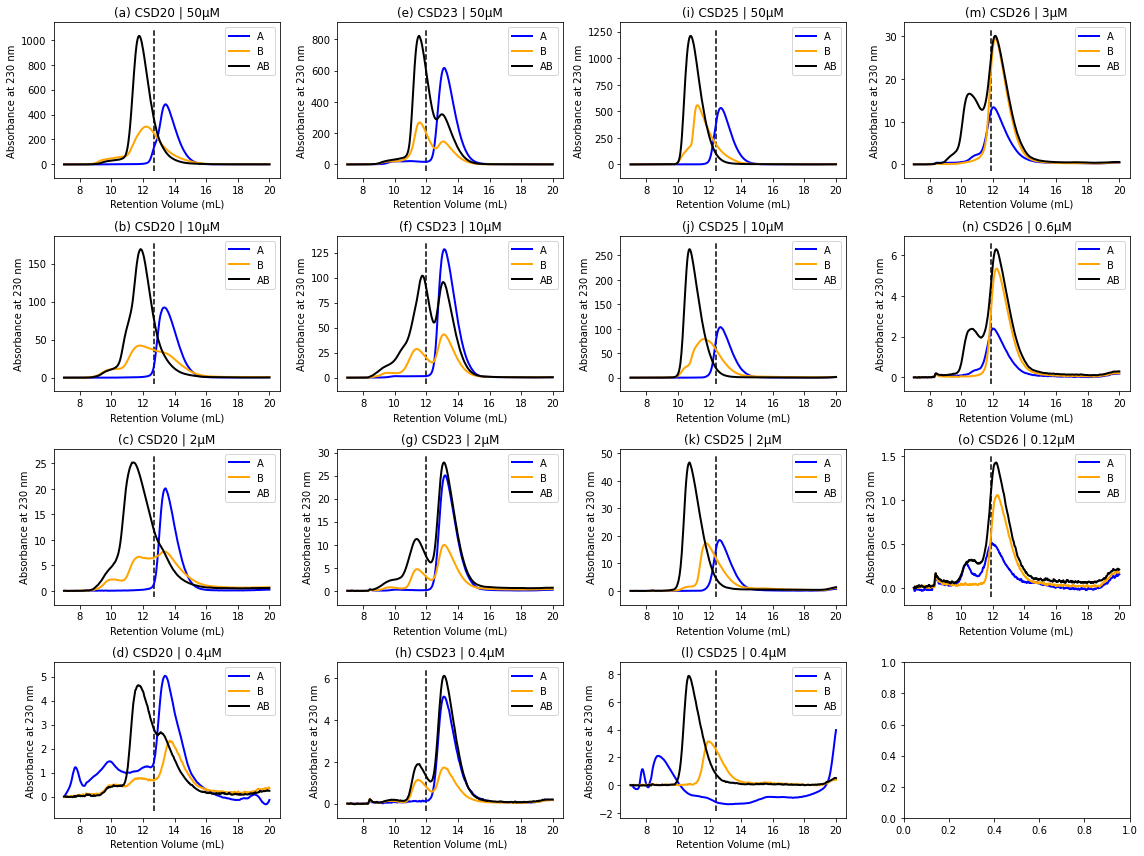

In [12]:
des_names = ['CSD20', 'CSD23', 'CSD25', 'CSD26']
all_fig_letters = [
    ['a', 'b', 'c', 'd'], 
    ['e', 'f', 'g', 'h'], 
    ['i', 'j', 'k', 'l'], 
    ['m', 'n', 'o']
]

protparams_df = pd.read_csv('/home/broerman/wetlab/gene_orders/dimeric_hinges/2022-01-05_CSD_round2/protparams.csv')

all_concs = [
    ['50', '10', '2', '0.4'],
    ['50', '10', '2', '0.4'],
    ['50', '10', '2', '0.4'],
    ['3', '0.6', '0.12'],
]

# finds the averages of the centers of the predicted monomer and dimer regions- this is the division between those regions
# sep_vols = [np.mean((np.mean((vols[0], vols[2])), vols[4])) for vols in elu_vols]

#initialize graph
fig,axs = plt.subplots(4, 4, figsize=(16,12))

xmin = 7.0
xmax = 20.0

uvs = ['230']

colors = ['blue', 'orange', 'black', 'green', 'magenta', 'yellow', 'red', 'purple', 'cyan', 'wheat', 'grey', 'pink', 'brown', 'springgreen','dodgerblue','darkslategray','darkblue','gainsboro','palegreen', 'crimson', 'lime', 'lightgrey','coral','chocolate']

#get specific zip file, otherwise run on all zips in directory
combos = ['A', 'B', 'AB']

for i, (des_name, fig_letters, concs) in enumerate(zip(des_names, all_fig_letters, all_concs)):
    for j, (letter, conc) in enumerate(zip(fig_letters, concs)):

        ax = axs[j][i]

        color_counter = 0

        des_inds = protparams_df['Gene ID'].str.startswith(des_name)
        # des_df.loc[:,'homodimer_MW'] = 2*des_df.loc[:,'Molecular Weight']
        protparams_df.loc[des_inds,'monomer_elution'] = (11.18-13.99)/(44-17)*(protparams_df.loc[des_inds,'Molecular Weight']/1000-17)+13.99
        protparams_df.loc[des_inds,'homodimer_elution'] = (11.18-13.99)/(44-17)*(2*protparams_df.loc[des_inds,'Molecular Weight']/1000-17)+13.99
        sep_vol = (protparams_df.loc[des_inds,'monomer_elution'].mean() + protparams_df.loc[des_inds,'homodimer_elution'].mean())/2
        

        files = ['raw/' + des_name + combo + '_' + conc + '.zip' for combo in combos]

        for file, combo in zip(files, combos):

            #grab the entire dataset
            full_df = parse_file(file)
            
            df = pd.DataFrame()

            for uv in uvs:
                try:
                    uv_df = get_UV(full_df, uv, False, xmin, xmax)
                    uv_df['uv ' + uv] = uv_df['uv ' + uv] - uv_df['uv ' + uv].iloc[0] # subtract baseline
                    df = pd.concat([df,uv_df],axis="columns",ignore_index=False)
                except ValueError:
                    print(f'UV {uv} not found in file {file}! Skipping!')
            if df.empty:
                print(f"unable to extract any data from {file}")
                continue

            print(f'Processing png for {file} with UV {", UV ".join(uvs)} from {xmin} to {xmax} mL')
            
            #graph data

            #use column name data instead of args.uv because some of the UVs may have failed
            for uv_label in df.columns[df.columns.str.contains("uv")]:

                vol_label = uv_label.replace("uv","vol")
                df_plot = df[[uv_label,vol_label]]

                df_plot.plot.line(x=vol_label, y=uv_label, ax=ax, color=colors[color_counter], label=combo, linewidth=2)

                color_counter += 1

        # xticks = ax.get_xticks()
        # xticklabels = ax.get_xticklabels()
        # # xticks = np.concatenate((xticks, np.asarray(vols)))
        # # xticklabels += ['A', 'AA', 'B', 'BB', 'AB']
        # xticks = np.concatenate((xticks, np.asarray(vols)))
        # xticklabels += ['Monomer', 'Dimer']
        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        # ax.set_xticks(vols)
        # ax.set_xticklabels(['Monomer', 'Dimer'])
        ax.set_xticks(np.arange(8, 22, 2))

        ax.plot([sep_vol, sep_vol], ax.get_ylim(), '--', color='black', zorder=0)
        ax.set_xlabel('Retention Volume (mL)')
        ax.set_ylabel('Absorbance at 230 nm')
        ax.set_title(f'({letter}) {des_name} | {conc}μM')
        
fig.tight_layout()
fig.savefig("csd_binding_titration.png", dpi=300, bbox_inches='tight')

Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
        vol 230      uv 230
0      7.003078 -105.613670
1      7.009711 -105.616196
2      7.016351 -105.615494
3      7.022990 -105.613708
4      7.029626 -105.614250
...         ...         ...
1952  19.972914 -105.089653
1953  19.979549 -105.085442
1954  19.986172 -105.082802
1955  19.992813 -105.080017
1956  19.999449 -105.077332

[1957 rows x 2 columns]
Chromatogram
{'FormatVersion': '9', 'UNICORNVersion': '7.3.0.473'}
added - orig data
added - orig data
added - orig data
        vol 230      uv 230
0      7.000300 -105.743347
1      7.006938 -105.742714
2      7.013575 -105.743088
3      7.020209 -105.740723
4      7.026849 -105.740448
...         ...         ...
1952  19.970133 -103.987213
1953  19.976772 -103.981514
1954  19.983406 -103.977470
1955  19.990042 -103.973373
1956  19.996912 -103.968842

[1957 rows x 2 columns]
Chromatogram
{'FormatVersion': '9', 

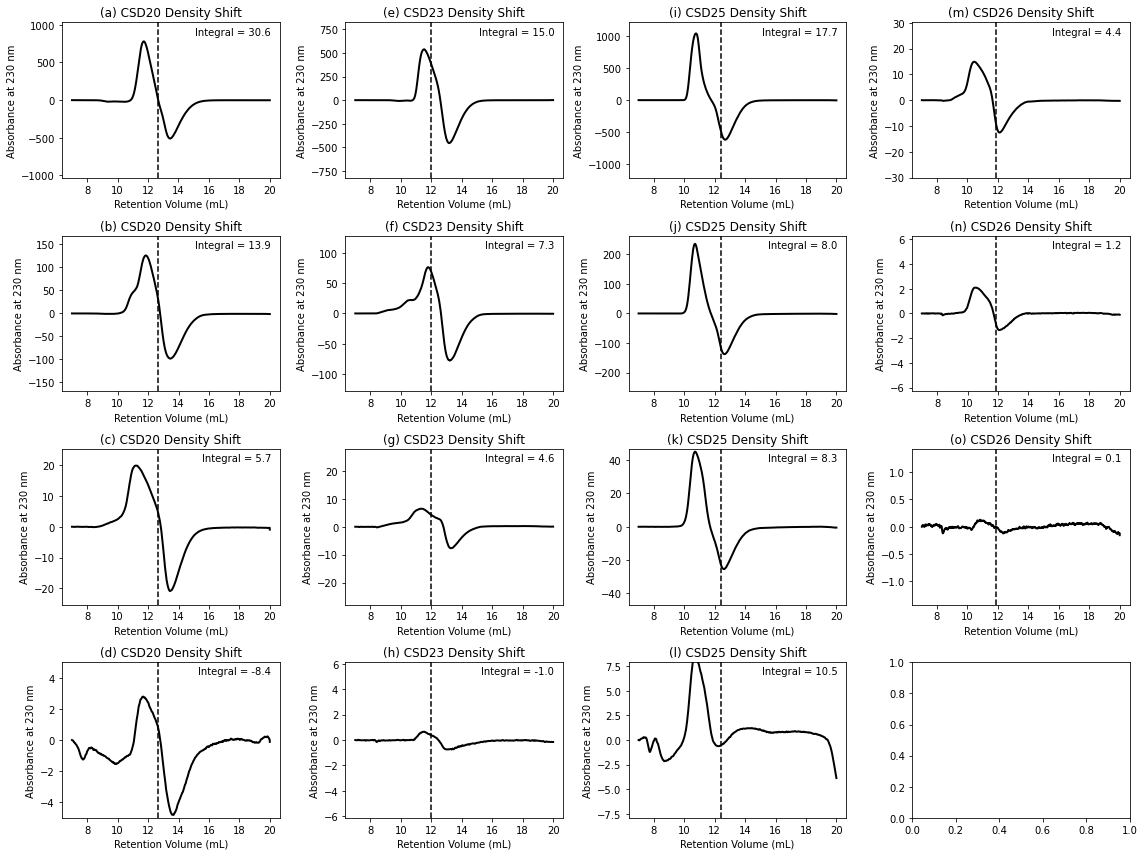

In [13]:
des_names = ['CSD20', 'CSD23', 'CSD25', 'CSD26']
all_fig_letters = [
    ['a', 'b', 'c', 'd'], 
    ['e', 'f', 'g', 'h'], 
    ['i', 'j', 'k', 'l'], 
    ['m', 'n', 'o']
]

protparams_df = pd.read_csv('/home/broerman/wetlab/gene_orders/dimeric_hinges/2022-01-05_CSD_round2/protparams.csv')

all_concs = [
    ['50', '10', '2', '0.4'],
    ['50', '10', '2', '0.4'],
    ['50', '10', '2', '0.4'],
    ['3', '0.6', '0.12'],
]

# finds the averages of the centers of the predicted monomer and dimer regions- this is the division between those regions
# sep_vols = [np.mean((np.mean((vols[0], vols[2])), vols[4])) for vols in elu_vols]

#initialize graph
fig,axs = plt.subplots(4, 4, figsize=(16,12))

xmin = 7.0
xmax = 20.0

uvs = ['230']

colors = ['blue', 'orange', 'black', 'green', 'magenta', 'yellow', 'red', 'purple', 'cyan', 'wheat', 'grey', 'pink', 'brown', 'springgreen','dodgerblue','darkslategray','darkblue','gainsboro','palegreen', 'crimson', 'lime', 'lightgrey','coral','chocolate']

#get specific zip file, otherwise run on all zips in directory
combos = ['A', 'B', 'AB']

for i, (des_name, fig_letters, concs) in enumerate(zip(des_names, all_fig_letters, all_concs)):
    for j, (letter, conc) in enumerate(zip(fig_letters, concs)):

        ax = axs[j][i]

        color_counter = 0

        des_inds = protparams_df['Gene ID'].str.startswith(des_name)
        # des_df.loc[:,'homodimer_MW'] = 2*des_df.loc[:,'Molecular Weight']
        protparams_df.loc[des_inds,'monomer_elution'] = (11.18-13.99)/(44-17)*(protparams_df.loc[des_inds,'Molecular Weight']/1000-17)+13.99
        protparams_df.loc[des_inds,'homodimer_elution'] = (11.18-13.99)/(44-17)*(2*protparams_df.loc[des_inds,'Molecular Weight']/1000-17)+13.99
        sep_vol = (protparams_df.loc[des_inds,'monomer_elution'].mean() + protparams_df.loc[des_inds,'homodimer_elution'].mean())/2
        

        files = ['raw/' + des_name + combo + '_' + conc + '.zip' for combo in combos]

        combined_uv = pd.Series(dtype='float64')

        vol_len = 0
        max_signal = 0
        for file, combo in zip(files, combos):

            #grab the entire dataset
            full_df = parse_file(file)
            df = get_UV(full_df, uv, False, xmin, xmax)
            print(df)
            
            #graph data

            uv_signal = df['uv ' + uv]
            uv_signal = uv_signal - uv_signal.iloc[0] # subtract baseline
        
            if combo == 'AB':
                combined_uv = combined_uv.add(uv_signal, fill_value=0)
            else:
                combined_uv = combined_uv.sub(uv_signal, fill_value=0)

            if len(df['vol ' + uv]) > vol_len:
                vols = df['vol ' + uv]
                vol_len = len(vols)
            if uv_signal.max() > max_signal:
                max_signal = uv_signal.max()

        ax.plot(vols, combined_uv, color=colors[2], linewidth=2) # if this fails because the x and y vectors don't match, could be because some of the UVs have one more data point than the others

        # integral = np.trapz(combined_uv - combined_uv.iloc[0], vols) # subtracts the baseline and integrates
        integral = np.trapz(combined_uv, vols) # subtracts the baseline and integrates

        ax.set_xticks(np.arange(8, 22, 2))
        ax.set_ylim(-max_signal, max_signal)
        ax.plot([sep_vol, sep_vol], ax.get_ylim(), '--', color='black', zorder=0)
        ax.text(0.96, 0.94, f'Integral = {integral:.01f}', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        ax.set_xlabel('Retention Volume (mL)')
        ax.set_ylabel('Absorbance at 230 nm')
        ax.set_title(f'({letter}) {des_name} Density Shift')
        
fig.tight_layout()
fig.savefig("csd_binding_titration_density_shift.png", dpi=300, bbox_inches='tight')